In [75]:
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [76]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train[y_train.squeeze() == 1]
X_train = (X_train / 127.5) - 1.0

IMG_SIZE = 28     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

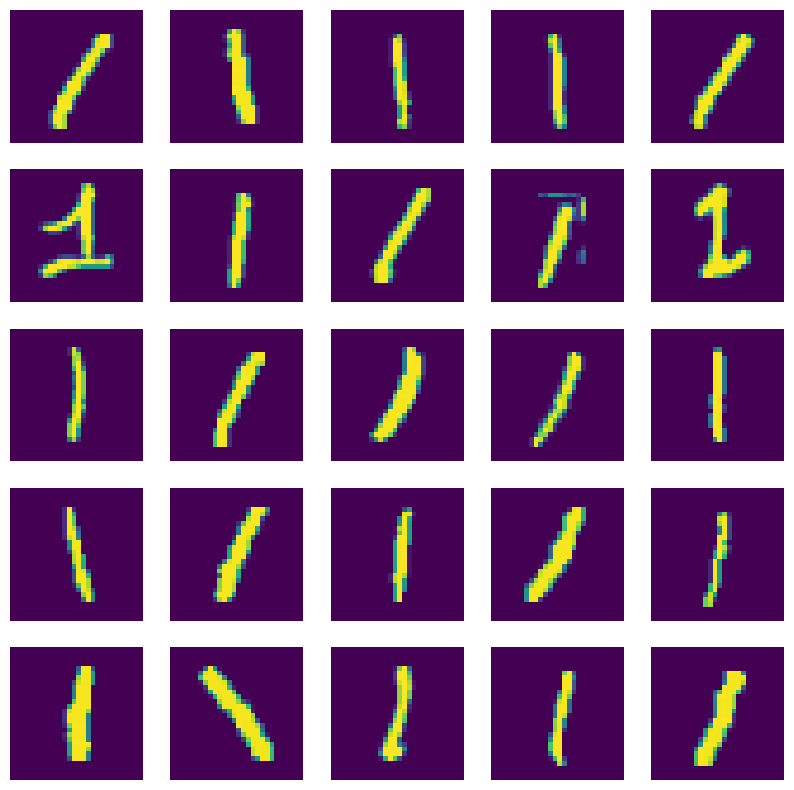

In [77]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_examples(X_train)

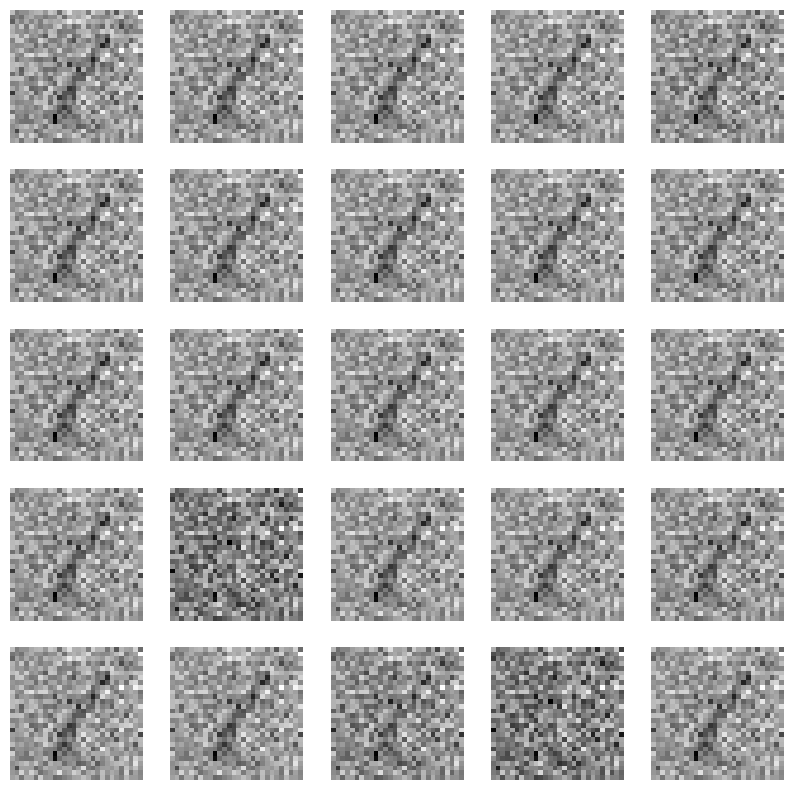

In [78]:
timesteps = 28  # Assuming MNIST images are 28x28

def forward_noise(x, t):
    a = t      # base on t
    b = (t + 1) % timesteps  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b

def generate_ts(num):
    return np.random.randint(0, timesteps - 1, size=num)

# Random time steps for training data
t = generate_ts(25)
a, b = forward_noise(X_train[:25], t)

# Display images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    axes[i // 5, i % 5].imshow(a[i][0].reshape((28, 28)), cmap='gray')  # Corrected reshaping
    axes[i // 5, i % 5].axis('off')
plt.show()



In [79]:
from tensorflow.keras import layers, models

def unet_model(input_shape=(28, 28, 1)):
    # Entrée
    inputs = layers.Input(input_shape)

    # Encodeur
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Niveau central
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Décodeur
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(128, 2, activation='relu', padding='same')(up4)
    merge4 = layers.Concatenate(axis=-1)([conv2, up4])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(64, 2, activation='relu', padding='same')(up5)
    merge5 = layers.Concatenate(axis=-1)([conv1, up5])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Couche de sortie
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    # Modèle U-Net complet
    model = models.Model(inputs, outputs)

    return model

# Créer le modèle
model = unet_model()
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_68 (Conv2D)          (None, 28, 28, 64)           640       ['input_5[0][0]']             
                                                                                                  
 conv2d_69 (Conv2D)          (None, 28, 28, 64)           36928     ['conv2d_68[0][0]']           
                                                                                                  
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 64)           0         ['conv2d_69[0][0]']           
 ng2D)                                                                                      

In [80]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

  0%|          | 0/28 [00:00<?, ?it/s]

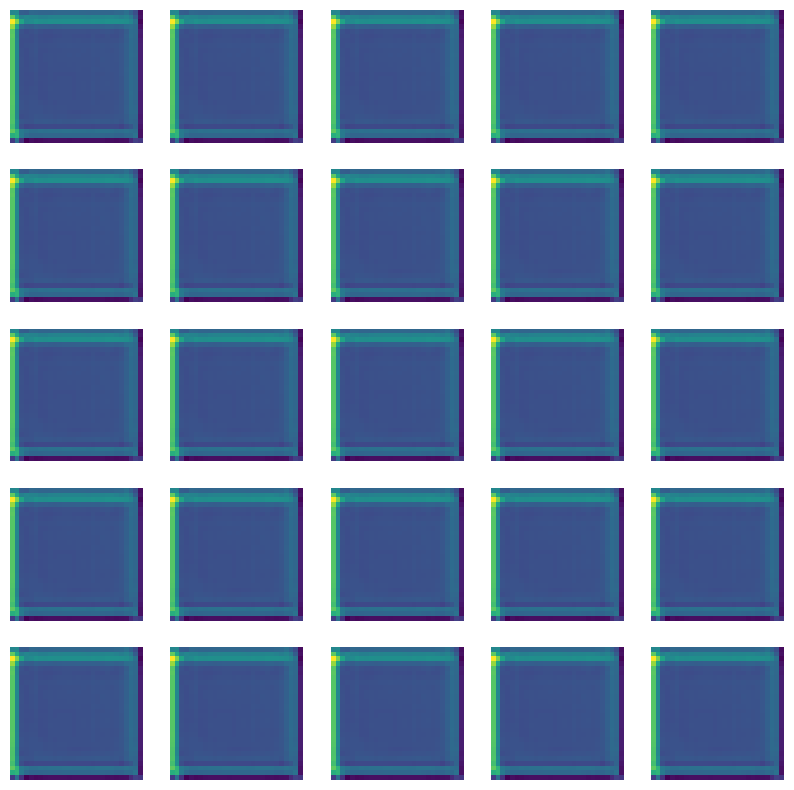

In [81]:
def predict():
    # generate random noise
    x = np.random.normal(size=(25, IMG_SIZE, IMG_SIZE, 1))
    for i in trange(timesteps):
        t = i
        x = model.predict((x), verbose=0)
    show_examples(x)

predict()

  0%|          | 0/28 [00:00<?, ?it/s]

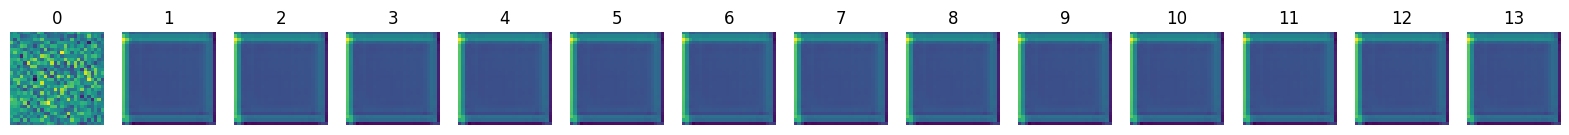

In [82]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 1))

    for i in trange(timesteps):
        t = i
        x = model.predict(x, verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [83]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

def train(R=50):
    bar = trange(R)
    total = 100
    for i in bar:
        for j in range(total):
            x_img = X_train[np.random.randint(len(X_train), size=BATCH_SIZE)]
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [84]:
for _ in range(10):
    train()
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result 
    predict()
    predict_step()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: in user code:

    File "C:\Users\Yanis\PycharmProjects\AI_generation\feur\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Yanis\PycharmProjects\AI_generation\feur\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Yanis\PycharmProjects\AI_generation\feur\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Yanis\PycharmProjects\AI_generation\feur\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Yanis\PycharmProjects\AI_generation\feur\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Yanis\PycharmProjects\AI_generation\feur\lib\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_4" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(128, 128, 28, 28) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(128,) dtype=int32>]
